## Домашняя работа 6
фев'24
<hr>

### Часть 1. EDA

<br>Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
<br>Пройдите по основным шагам работы с данными:
<ul><li>выкиньте ненужные признаки: id, name, host_id, host_name, last_review</li>
<li>визуализируйте базовые статистики данных: распределения признаков, матрицу попарных корреляций, постройте pair plots</li>
<li>про результатам анализа произведите предобработку переменных</li></ul>

In [1]:
# !pip install numpy pandas seaborn matplotlib plotly scikit-learn kaggle category_encoders
# !pip install pyarrow # !!!!!!!!!!!!!!!!!

In [2]:
%%time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML, display


Wall time: 1.96 s


In [3]:
def color_text(val):
    if val == 0:
        color = 'red'
    else:
        color = 'black'
    return 'color: %s' % color

def short_describe(df, sample_size=5, repiter=125):
    repiter='>'*repiter
    nRow, nCol = df.shape
    display(HTML(f'<b>There are {nRow} rows and {nCol} columns<br>Duplicates: {df.duplicated().sum()}</b><hr>'))
    d_test=df.sample(n=sample_size, random_state=202402).T
    d_test['datatypes']=df.dtypes
    d_describe=df.describe(include='all').T
    
    for i in ['count','min','mean','max','std', 'unique', 'freq']:
        d_test[i]=d_describe[i]
#         if i in ['min','mean',]:
#             d_test[i].fillna('-', inplace=True)

    d_test['max'].fillna(d_test['unique'], inplace=True)
    d_test['std'].fillna(d_test['freq'], inplace=True)
    d_test.rename(columns = {'max':'max / unique','std':'std / freq'}, inplace = True)
    d_test=d_test.drop(columns=['unique','freq'])
    
    d_test['nulls']=df.isnull().sum()
    
    display(d_test.style.set_na_rep("").applymap(color_text))
    
    display(HTML("<hr><b>Null values</b>"))
    sns.heatmap(df.isnull().T,cbar=True,cmap='gray_r',xticklabels=False)
    plt.show()    
    
    lst_num = df.select_dtypes(include='number').columns.tolist()
    lst_str = df.select_dtypes(include='object').columns.tolist()
    display(HTML(f'<hr><b>Numeric columns ({len(lst_num)}):</b>'))
    print(lst_num)
    display(HTML(f'<hr><b>String columns ({len(lst_str)}):</b>'))
    print(lst_str)

    
    display(HTML("<hr>"))
    return lst_num, lst_str

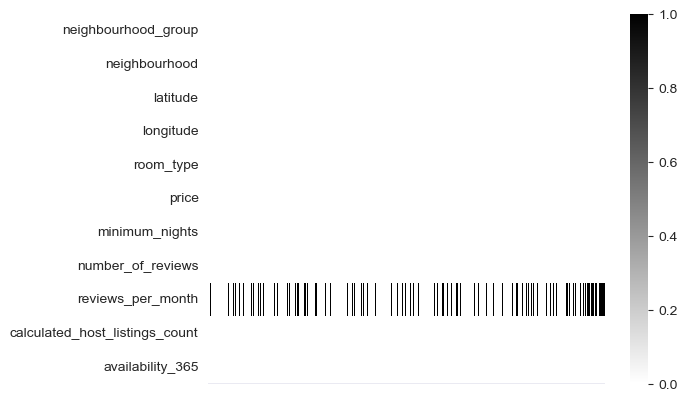

['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


['neighbourhood_group', 'neighbourhood', 'room_type']


Wall time: 1.62 s


In [4]:
%%time

strFileName='AB_NYC_2019.csv'

# # Reasearch in sample
# topNrows = 5000
# df = pd.read_csv(strFileName, delimiter=',', nrows = topNrows)

df = pd.read_csv(strFileName, delimiter=',', engine='pyarrow')

df=df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'])

cols_num, cols_str= short_describe(df)

<hr>

### Test correlation on sample

In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df=df[cols_num], crit=0.85, method='spearman'):    
    au_corr = df.corr(method=method).abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[au_corr>crit]


In [6]:
crit=0.8
corr_df=df[cols_num].sample(n=1000,random_state=202402)
result=get_top_abs_correlations(df=corr_df, crit=crit, method='pearson')
display(HTML(f'<b>Strong correlation (>{crit}): {result.shape[0]} pairs</b><hr>'))
print(result)

Series([], dtype: float64)


The most likely candidate for drop is field <b>number_of_reviews</b>,<br>
which is obviously closely related to field <b>reviews_per_month</b>

#CODE

drop_candidate='number_of_reviews'

df=df.drop(columns=drop_candidate)

cols_num.remove(drop_candidate)


<hr>

### Correlation matrix (triangular)

In [7]:
corr_df= df.corr(method='pearson').abs()
df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))
df_lt.style.background_gradient().highlight_null(null_color="white").set_na_rep("")

### Nominal feaches

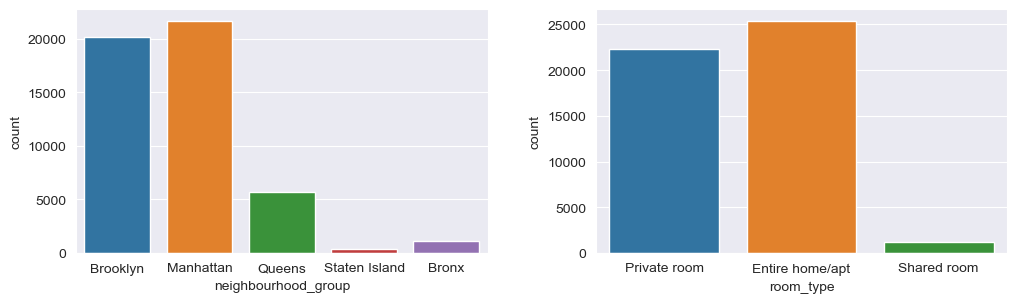

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
fig.tight_layout(h_pad=5,w_pad=5)
sns.countplot(ax=ax[0],x='neighbourhood_group',data=df)
sns.countplot(ax=ax[1],x='room_type',data=df)
plt.show()

In [9]:
pivot_df=pd.pivot_table(df, values='price',
                        index=['neighbourhood_group'],columns=['room_type'],
                        aggfunc={"mean","count","std"})
display(pivot_df.style.background_gradient())

<hr>

### Numeric feaches

#### Price

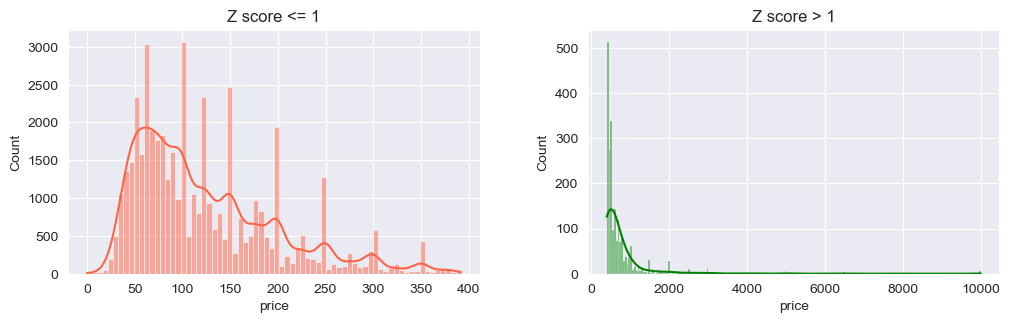

In [10]:
from scipy.stats import zscore

fig, ax = plt.subplots(1, 2, figsize=(10,3))
fig.tight_layout(h_pad=5,w_pad=5)

crit=1
sns.histplot(ax=ax[0],
             data=df.where(zscore(df['price']) <= crit),
             kde=True,x='price', color='tomato')
ax[0].set_title(f'Z score <= {crit}')

sns.histplot(ax=ax[1],
             data=df.where(zscore(df['price']) > crit),
             kde=True,x='price', color='green')
ax[1].set_title(f'Z score > {crit}')

display(HTML(f'<img src="Normal_distribution_and_scales.gif" width="500"/>'))

plt.show()

In [11]:
zero_price_rows=df[df["price"]==0]
display(HTML(f'It is necessary to <b> <span style="color:red">DROP</span> {zero_price_rows["price"].count()} rows </b> with zero price<hr>'))
display(zero_price_rows)

neighbourhood_group       neighbourhood  latitude  longitude  \
23161            Brooklyn  Bedford-Stuyvesant  40.69023  -73.95428   
25433               Bronx     East Morrisania  40.83296  -73.88668   
25634            Brooklyn            Bushwick  40.69467  -73.92433   
25753            Brooklyn          Greenpoint  40.72462  -73.94072   
25778            Brooklyn        Williamsburg  40.70838  -73.94645   
25794            Brooklyn  Bedford-Stuyvesant  40.68173  -73.91342   
25795            Brooklyn  Bedford-Stuyvesant  40.68279  -73.91170   
25796            Brooklyn  Bedford-Stuyvesant  40.68258  -73.91284   
26259           Manhattan         Murray Hill  40.75091  -73.97597   
26841            Brooklyn            Bushwick  40.69211  -73.90670   
26866            Brooklyn            Bushwick  40.69166  -73.90928   

             room_type  price  minimum_nights  number_of_reviews  \
23161     Private room      0               4                  1   
25433     Private room      0               2                 55   
25634     Private room      0               2                 16   
25753     Private room      0               2                 12   
25778  Entire home/apt      0               5                  3   
25794     Private room      0               1                 93   
25795     Private room      0               1                 95   
25796     Private room      0               1                 95   
26259  Entire home/apt      0               3                  0   
26841      Shared room      0              30                  2   
26866      Shared room      0              30                  5   

       reviews_per_month  calculated_host_listings_count  availability_365  
23161               0.05                               4                28  
25433               2.56                               4               127  
25634               0.71                               5                 0  
25753               0.53                               2                 0  
25778               0.15                               1                73  
25794               4.28                               6               176  
25795               4.37                               6               232  
25796               4.35                               6               222  
26259                NaN                               1                 0  
26841               0.11                               6               333  
26866               0.26                               6               139

#### reviews_per_month

In [12]:
tempdata_df=df.loc[df['reviews_per_month'].isnull()]
display(tempdata_df['number_of_reviews'].describe().to_frame().T)

display(HTML(f'<b><span style="color:red">Hypothesis: </span></b>  reviews_per_month = number_of_reviews / month_count<hr>'))


count  mean  std  min  25%  50%  75%  max
number_of_reviews  10052.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

<hr>

### Pairplot

Wall time: 14.1 s


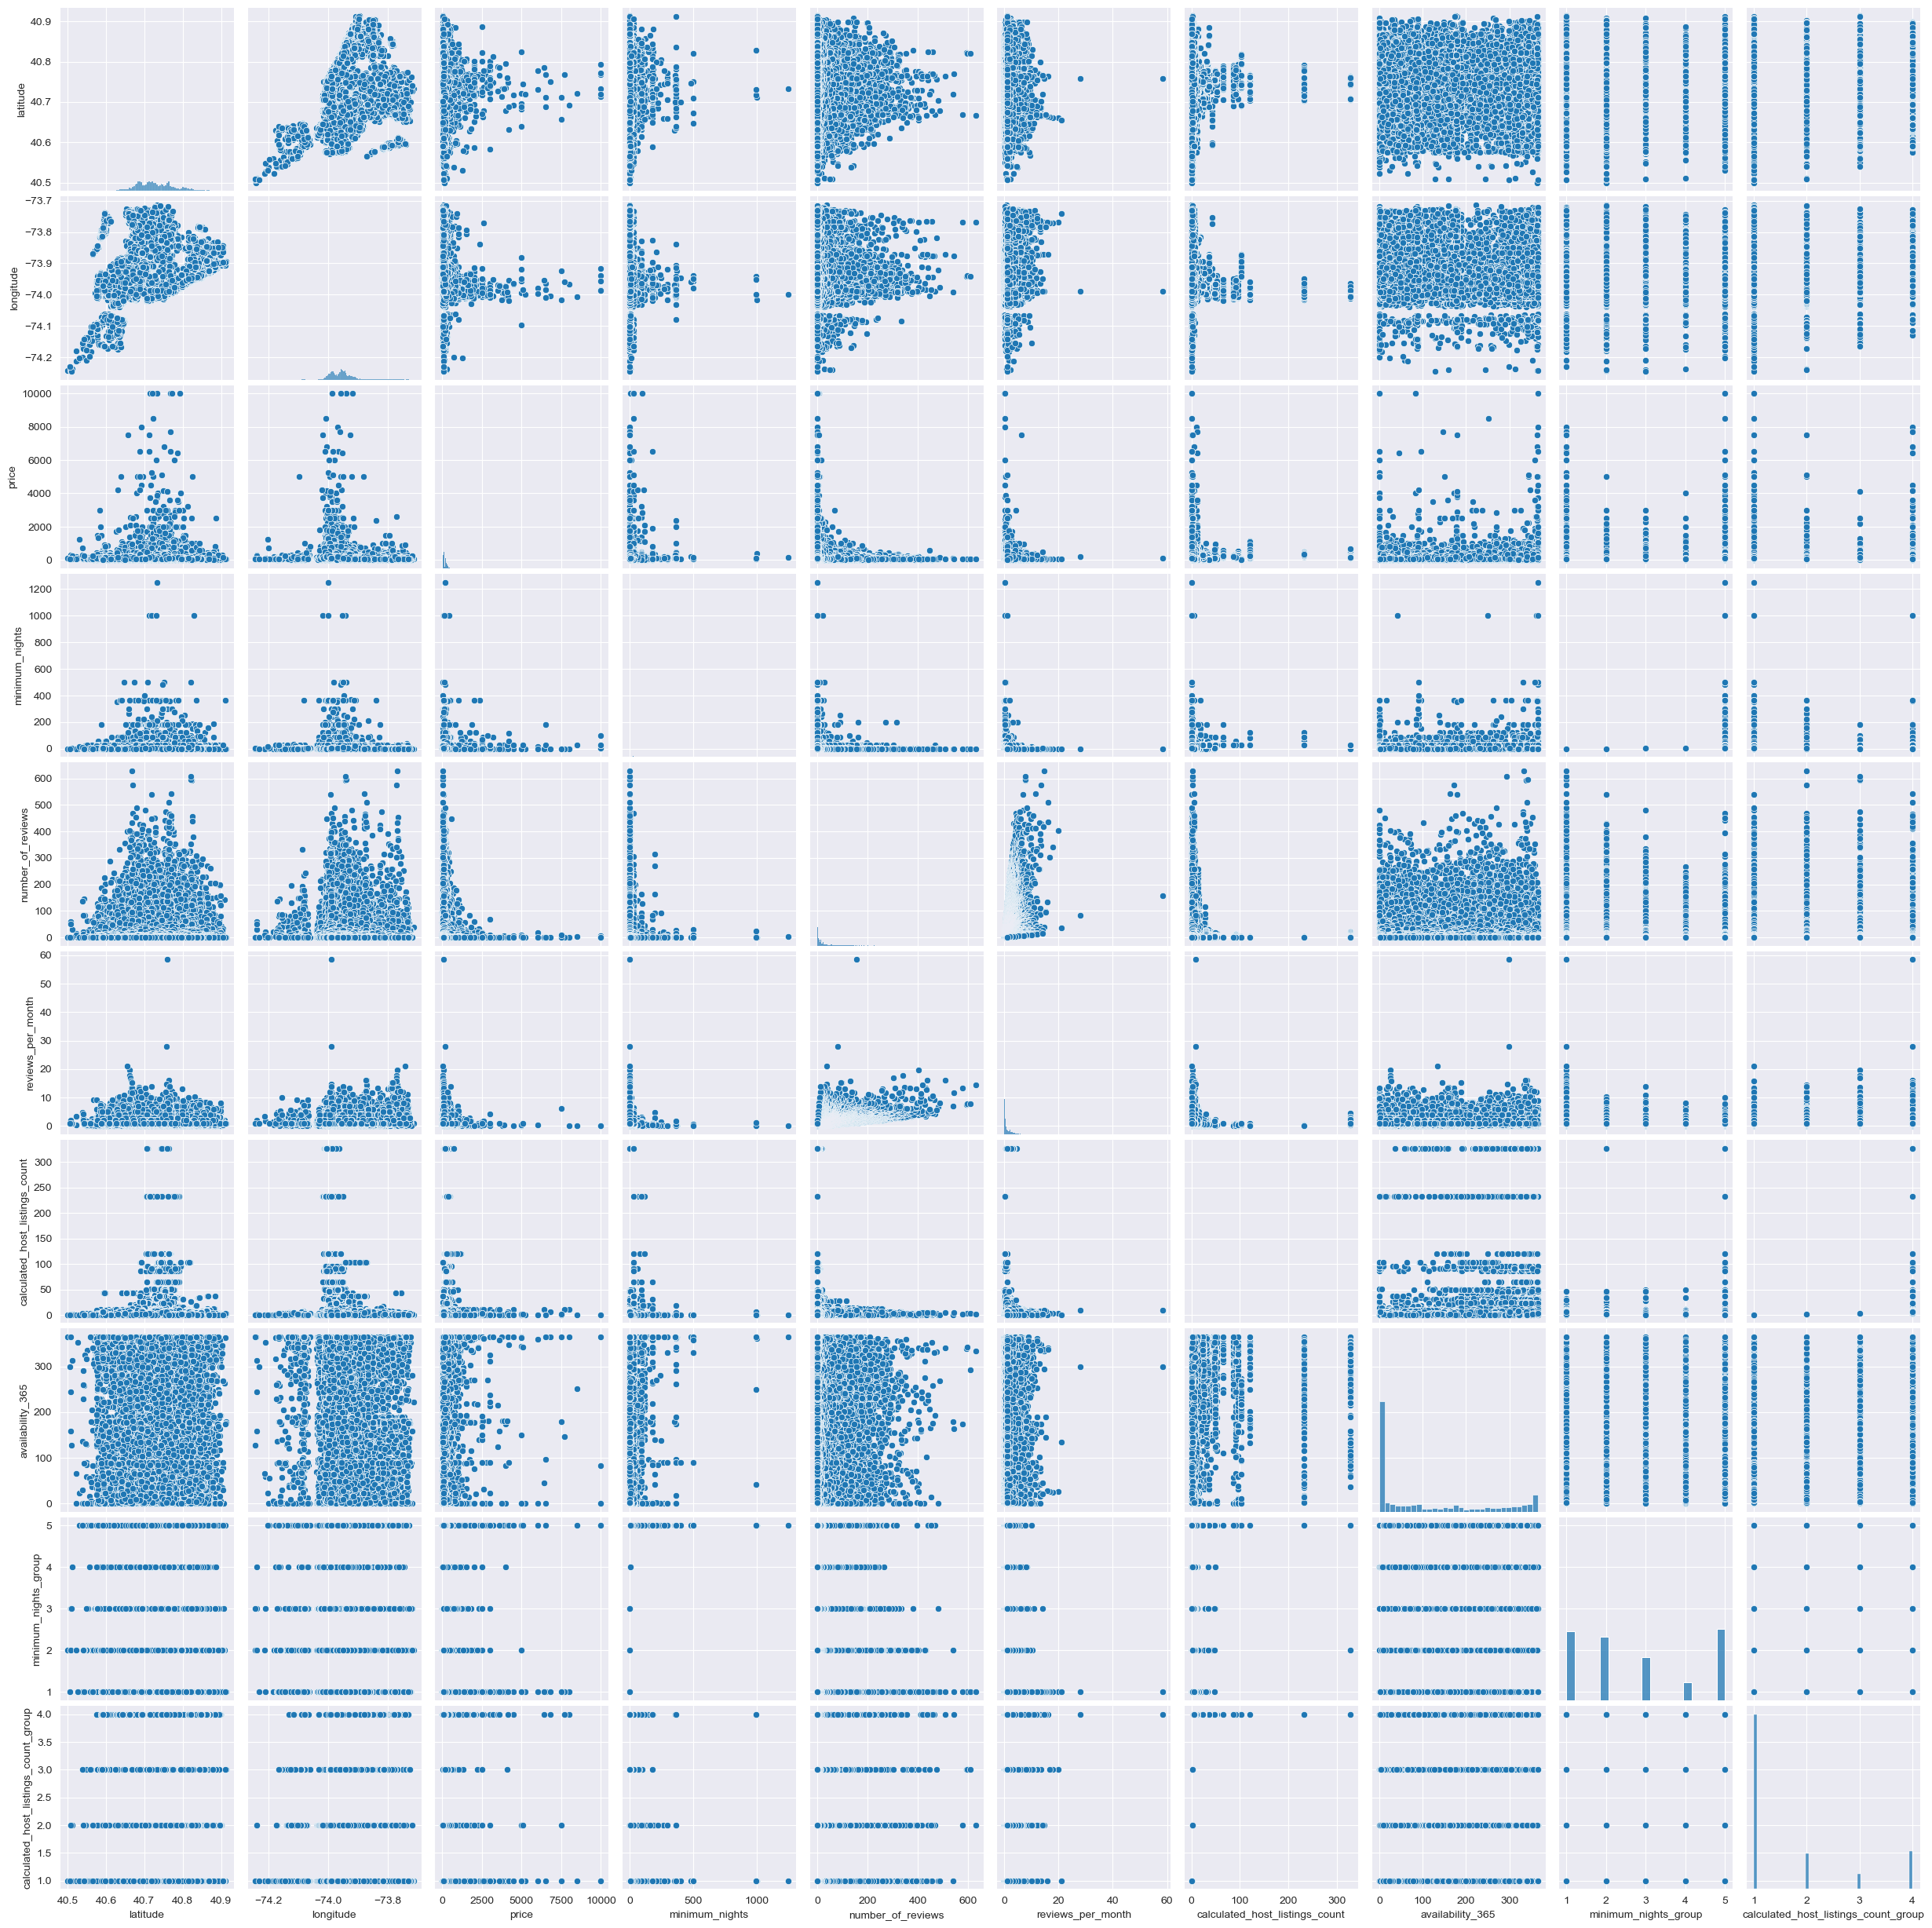

In [14]:
%%time
sns.pairplot(data=df)

<hr>

### Часть 2. Preprocessing & Feature Engineering

<br>Ваша цель получить как можно более высокие метрики качества (можно взять несколько, R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.
<br>Опробуйте различные техники:
<ul><li>работа с категориальными переменными (можно начать с dummy);</li>
<li>замена аномалий;</li>
<li>различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler, и.т.д.);</li>
<li>обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать;</li>
</ul>
Попробуйте на основании имеющихся переменных создать новые, которые могли бы улучшить качество модели. Например, можно найти координаты Манхэттена (самого дорогого района) и при помощи широты и долготы, а также евклидового расстояния создать новую переменную - расстояние от квартиры до этого района. Возможно, такой признак будет работать лучше, чем просто широта и долгота.

#### Price

DROP 11 rows with zero price 

In [15]:
df = df.drop(df[df['price'] == 0].index)

Max price

<i>Additional research</i>

In [16]:
df_z_price=df[['neighbourhood_group','room_type','price']]

df_z_price['z_price']=zscore(df_z_price['price']).abs()
df_z_price['z_price_group']=round(df_z_price['z_price'],0)
df_z_price.loc[df_z_price["z_price_group"]>4, "z_price_group"] = 4

display(df_z_price.value_counts('z_price_group',normalize=True).to_frame().T)

pivot_df=pd.pivot_table(df_z_price, values='price',
                        columns=['z_price_group'], index=['room_type'],
                        aggfunc={"mean","count","min"})
display(pivot_df)

z_price_group       0.0       1.0       2.0       4.0       3.0
0              0.885484  0.093343  0.010781  0.006567  0.003825

count                             mean              \
z_price_group      0.0   1.0  2.0  3.0  4.0         0.0         1.0   
room_type                                                             
Entire home/apt  21047  3476  473  156  255  151.774552  349.934983   
Private room     21394   782   53   28   62   78.818033  163.997442   
Shared room        845   305    1    3    4   68.353846   50.537705   

                                                     min                      
z_price_group           2.0         3.0          4.0 0.0 1.0  2.0  3.0   4.0  
room_type                                                                     
Entire home/apt  634.947146  847.923077  2110.200000  33  10  515  760   995  
Private room     633.641509  872.142857  2128.516129  33  10  515  794   995  
Shared room      725.000000  800.000000  1262.500000  33  10  725  800  1000

In [17]:
print('\nSet price upper bound: ',df_z_price[df_z_price['z_price_group']>=2]['price'].min())

df['target_price']=df['price']
df.loc[df["target_price"]>515, "target_price"] = 515

display(df["target_price"].describe().to_frame().T)


Set price upper bound:  515


count        mean        std   min   25%    50%    75%    max
target_price  48884.0  139.748179  103.24311  10.0  69.0  106.0  175.0  515.0

#### New columns

<b><span style="color:red">depricated:</span></b> <span style="color:lightgray">'latitude', 'longitude' -> to one field. </span>

reviews_per_month -> reviews_months

In [18]:
col_target='reviews_months'
df[col_target]=df['number_of_reviews']/df['reviews_per_month']
df[col_target].fillna(0, inplace=True)
df[col_target] = df[col_target].astype('int')
df[col_target].describe().to_frame().T

count       mean        std  min  25%   50%   75%    max
reviews_months  48884.0  21.603592  22.740008  0.0  1.0  14.0  35.0  128.0

minimum_nights -> minimum_nights_group

calculated_host_listings_count_group -> calculated_host_listings_count

In [19]:
columns_list=(('minimum_nights_group',
               'minimum_nights'),
              ('calculated_host_listings_count_group',
               'calculated_host_listings_count')
             )

for i in columns_list:
    df[i[0]]=df[i[1]]
    df.loc[df[i[1]]>4, i[0]] = 5
    display(df[i[0]].describe().to_frame().T)


count      mean       std  min  25%  50%  75%  max
minimum_nights_group  48884.0  2.847046  1.549828  1.0  1.0  3.0  5.0  5.0

count      mean      std  min  25%  \
calculated_host_listings_count_group  48884.0  1.802246  1.35469  1.0  1.0   

                                      50%  75%  max  
calculated_host_listings_count_group  1.0  2.0  5.0

<hr>

### Map

In [24]:
lat = np.mean(df['latitude'])
lon = np.mean(df['longitude'])


fig = px.density_mapbox(df, lat='latitude', lon='longitude', z='target_price', radius=2,
                        center=dict(lat = lat, lon = lon), zoom=10,
                        mapbox_style="carto-positron")
fig.show()

<hr>

### Часть 3. Моделирование

<br>Отложите 30% данных для тестирования.
<br>Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.
<br>Измерьте качество каждой и визуализируйте важность признаков.
<br>Сделайте интересные выводы :)

In [37]:
# define columns for modeling

cols_num=[
    'latitude','longitude',
    'number_of_reviews','reviews_months',  # <- new column
    'minimum_nights_group','calculated_host_listings_count_group','availability_365',
]

cols_str=[
    'room_type',
    'neighbourhood_group',
    'neighbourhood',
]

col_feaches=[]

col_target=['target_price']

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results=pd.DataFrame()

def metrics_df(model, X_train, X_test, y_train, y_test, results=results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    d={
        'model' : type(model).__name__,
        'MAE'   : mean_absolute_error(y_test, y_pred),
        'MSE'   : mean_squared_error(y_test, y_pred),
        'R2'    : r2_score(y_test, y_pred),
    }
    ret_df=pd.concat([results,
                      pd.DataFrame(data=d)],
                     ignore_index=True)
    return ret_df

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from category_encoders import CountEncoder
encoders = [
    OneHotEncoder(),
    OrdinalEncoder(),
    LabelEncoder(),
    CountEncoder(),
]

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scalers = [
    MinMaxScaler(),
    RobustScaler(),
    StandardScaler(),
]

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
models = [
    LinearRegression(),
    RidgeCV(cv=5),
    LassoCV(cv=5, random_state=202402),
    ElasticNetCV(cv=5, random_state=202402)
]

In [32]:
from sklearn.model_selection import train_test_split

test_size=.3
train_size=1-test_size

df_model = df[col_feaches + col_target]

X = df_model.drop([col_target], axis=1)
y = df_model[col_target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=202402)
print('train_x:',train_x.shape, 'train_y:',train_y.shape)
print('test_x:' ,test_x.shape,  'test_y:' ,test_y.shape)

NameError: name 'X' is not defined

In [ ]:
scaler = StandardScaler()
df[cols_num] = scaler.fit_transform(df[cols_num])
df[cols_num].describe().T